<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being able to extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression or any other suitable classifier.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters:

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [1]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [2]:
import requests
import bs4
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
## YOUR CODE HERE
html = requests.get(URL)
# page = response.text
soup = BeautifulSoup(html.text, 'html.parser')

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

Example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it.
    - Remember to use `try/except` if you anticipate errors.
- **Test** the functions on the results above and simple examples.

In [4]:
## YOUR CODE HERE
def extract_location_from_result(soup):
    location_list=[]
    html = soup.find_all('div', {'class':'companyInfoWrapper'})
    for loc in html:
        if loc.find('span',{'class':'location'}):
            location_list.append(loc.find('span',{'class':'location'}).text)
        else: 
            location_list.append(None)
    return location_list

In [6]:
def extract_job_title_from_result(soup):
    title_list = []
    for title in soup.find_all('a',{'class':'turnstileLink'}):
        try:
            title_list.append(title['title'])
        except:
            title_list.append('non')
    return title_list

In [8]:
def extract_company_from_result(soup):
    company_list = []
    html = soup.find_all('div', {'class':'companyInfoWrapper'})
    for company in html:
        try:
            company_list.append(company.find('span',{'class':'company'}).text.strip())
        except:
            company_list.append('non')
    return company_list

In [10]:
def extract_salary_from_result(soup):
    salaries_list = []
    for salary in soup.find_all('td', {'class':'snip'}):
        if salary.find('span',{'class':'salary no-wrap'}):
            salaries_list.append(salary.find('span',{'class':'salary no-wrap'}).text.strip())
        else:
            salaries_list.append(None)
    return salaries_list

In [ ]:
def extract_salary_from_result(soup):
    salaries = []
    for div in soup.find_all(name="div", attrs={"class":"row"}):
       ## from salary in indeed we use span
        salary = div.find(name="span", attrs={"class":"salary"})
        if salary:
            salaries.append(salary.text.strip())
        else:
            salaries.append(None)

    return(salaries)

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

#### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search.
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different.

In [26]:
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 100 # Set this to a high-value (5000) to generate more results. 
# Crawling more results, will also take much longer. First test your code on a small number of results and then expand.

results = []

for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
    'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami']):
    for start in range(0, max_results_per_city, 10):
        # Grab the results from the request (as above)
        r=requests.get(url_template.format(city,start))
        soup2=BeautifulSoup(r.text,'html.parser')
        # Append to the full set of results
        results.append(soup2)
        pass

In [27]:
len(results)

150

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [28]:
## YOUR CODE HERE
indeed_df=pd.DataFrame()

for soup in results:
    df=pd.DataFrame()
    df['job_title'] = extract_job_title_from_result(soup)
    df['company_name'] = extract_company_from_result(soup)
    df['location']= extract_location_from_result(soup)
    df['salary']= extract_salary_from_result(soup)
    indeed_df = indeed_df.append(df,ignore_index=True)

In [29]:
indeed_df.shape

(1496, 4)

In [30]:
indeed_df.tail()

,job_title,company_name,location,salary
1491,"Learning Scientist / Spanish Expert, PhD",Duolingo,"Pittsburgh, PA",None
1492,Software Engineer (Infrastructure),Facebook,"Pittsburgh, PA","$94,000 - $141,000 a year (Indeed est.)"
1493,Sr. Analytics Consultant – BI & Big Data Scrum...,EXL,"Pittsburgh, PA","$101,000 - $152,000 a year (Indeed est.)"
1494,Laboratory IS Clinical Application Specialist,Gila River Health Care,"Laboratory, PA",None
1495,Senior Sales Manager - Pittsburgh,JUUL Labs,"Pittsburgh, PA",None


Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries.

In [31]:
## YOUR CODE HERE
indeed_df['salary'].value_counts()

$53,200 - $79,800 a year                    4
$52,139 - $67,781 a year                    4
$40,000 a year                              3
$94,000 - $139,000 a year (Indeed est.)     3
$2,406 - $3,105 a month                     3
$35,034 - $54,068 a year                    2
$2,776 - $3,506 a month                     2
$41,600 - $64,050 a year                    2
$41,812 - $65,073 a year                    2
$3,191 - $4,253 a month                     2
$18.50 an hour                              2
$3,105 - $4,040 a month                     2
$113,000 - $166,000 a year (Indeed est.)    2
$33,394 - $164,200 a year                   2
$59,694 - $77,603 a year                    2
$116,000 - $171,000 a year (Indeed est.)    2
$92,000 - $136,000 a year (Indeed est.)     2
$12 an hour                                 2
$65 - $75 an hour                           2
$101,000 - $149,000 a year (Indeed est.)    2
$82,000 - $129,996 a year                   2
$102,000 - $136,000 a year (Indeed

In [32]:
indeed_df.isnull().sum() 

job_title          0
company_name       0
location           0
salary          1365
dtype: int64

In [33]:
# Obtain only values with salary entries
indeed_df[indeed_df['salary'].notnull()]['salary']

22      $101,000 - $148,000 a year (Indeed est.)
23       $95,000 - $140,000 a year (Indeed est.)
25      $113,000 - $166,000 a year (Indeed est.)
27      $116,000 - $171,000 a year (Indeed est.)
29       $86,000 - $127,000 a year (Indeed est.)
49                      $45,180 - $75,298 a year
50                      $70,000 - $90,000 a year
142                     $53,200 - $66,500 a year
145                     $53,200 - $79,800 a year
154                     $53,200 - $79,800 a year
161                     $53,200 - $79,800 a year
181                      $3,223 - $4,834 a month
182                     $53,200 - $79,800 a year
189                               $65,000 a year
204                               $40,000 a year
223                     $67,000 - $72,000 a year
230                     $59,694 - $77,603 a year
234                     $52,139 - $67,781 a year
240                     $52,139 - $67,781 a year
241                               $18.50 an hour
242                 

In [34]:
# Remove hourly and monthly salary data - only keeping yearly data
monthmask = indeed_df[(indeed_df['salary'].isnull()==False) & (indeed_df['salary'].str.contains('month'))]
hourmask = indeed_df[(indeed_df['salary'].isnull()==False) & (indeed_df['salary'].str.contains('hour'))]

indeed_df.drop(monthmask.index, inplace=True)
indeed_df.drop(hourmask.index, inplace=True)

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary.

In [35]:
## YOUR CODE HERE
def converting_salary(salary):
    salary = str(salary)
    salary = salary.replace(",","").replace("$","").replace("-"," ") #all salaries in dollars
    salary = [int(s) for s in salary.split() if s.isdigit()]
    if len(salary)>1:
        salary = (sum(salary)/2)
    else:
        salary = (sum(salary))a
    return salary

In [42]:
sal=[]
for x in indeed_df['salary']:
    sal.append(converting_salary(x))
    
indeed_df['avg_salary'] = sal

In [44]:
indeed_df.tail()

,job_title,company_name,location,salary,avg_salary
1491,"Learning Scientist / Spanish Expert, PhD",Duolingo,"Pittsburgh, PA",None,0.0
1492,Software Engineer (Infrastructure),Facebook,"Pittsburgh, PA","$94,000 - $141,000 a year (Indeed est.)",117500.0
1493,Sr. Analytics Consultant – BI & Big Data Scrum...,EXL,"Pittsburgh, PA","$101,000 - $152,000 a year (Indeed est.)",126500.0
1494,Laboratory IS Clinical Application Specialist,Gila River Health Care,"Laboratory, PA",None,0.0
1495,Senior Sales Manager - Pittsburgh,JUUL Labs,"Pittsburgh, PA",None,0.0


### Save your results as a CSV

In [ ]:
## YOUR CODE HERE
indeed_df.to_csv('./project-4.csv', index=False)

## QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your model's performance.

#### Load in the the data of scraped salaries

In [51]:
## YOUR CODE HERE
v2_df=pd.read_csv('./project-4.csv')

In [52]:
# indeed_df.shape, v2_df.shape

In [53]:
v2_df.dropna(inplace=True)
print(v2_df.shape)
v2_df.reset_index(inplace=True, drop=True)
v2_df.head()

(99, 5)


,job_title,company_name,location,salary,avg_salary
0,Data Scientist,Dollar Shave Club,"Marina del Rey, CA 90292","$101,000 - $148,000 a year (Indeed est.)",124500.0
1,Staff Data Scientist,Areté Associates,"Northridge, CA","$95,000 - $140,000 a year (Indeed est.)",117500.0
2,NLP Data Scientist,Albert,"Los Angeles, CA","$113,000 - $166,000 a year (Indeed est.)",139500.0
3,Data Scientist - Healthcare,Beyond Limits,"Glendale, CA","$116,000 - $171,000 a year (Indeed est.)",143500.0
4,Data Scientist,Hearts and Science,"Burbank, CA","$86,000 - $127,000 a year (Indeed est.)",106500.0


#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [54]:
## YOUR CODE HERE
new_df = v2_df[v2_df['salary'].notnull()]
new_df.shape

(99, 5)

In [55]:
median = new_df['avg_salary'].median()

In [56]:
#find salaies above the median
new_df['salary_binary'] = new_df['avg_salary'].apply(lambda x: 1 if x > median else 0)

In [57]:
new_df.tail()

,job_title,company_name,location,salary,avg_salary,salary_binary
94,"Research Engineering Scientist Associate III, ...",University of Texas at Austin,"Austin, TX","$55,000 a year",55000.0,0
95,Senior Software Engineer - Artificial Intellig...,Redhorse Corporation,"Carnegie, PA 15106","$102,000 - $136,000 a year (Indeed est.)",119000.0,1
96,AVMaps Workflow Technical Lead Manager / TLM,Uber,"Pittsburgh, PA 15201 (Central Lawrenceville area)","$106,000 - $157,000 a year (Indeed est.)",131500.0,1
97,Software Engineer (Infrastructure),Facebook,"Pittsburgh, PA","$94,000 - $141,000 a year (Indeed est.)",117500.0,1
98,Sr. Analytics Consultant – BI & Big Data Scrum...,EXL,"Pittsburgh, PA","$101,000 - $152,000 a year (Indeed est.)",126500.0,1


In [58]:
new_df["salary_binary"].value_counts()

0    50
1    49
Name: salary_binary, dtype: int64

#### Thought experiment: What is the baseline accuracy for this model?

In [59]:
(1- np.mean(new_df['salary_binary']))

0.505050505050505

### Create a classification model to predict High/Low salary. 


#### Model based on location:

- Start by ONLY using the location as a feature. 
- Use logistic regression with both statsmodels and sklearn.
- Use a further classifier you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.

#### Model taking into account job levels and categories:

- Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title or whether 'Manager' is in the title. 
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value? 
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models. 
- Discuss model coefficients or feature importances as applicable.

#### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. 


- Use cross-validation to evaluate your models. 
- Evaluate the accuracy, AUC, precision and recall of the models. 
- Plot the ROC and precision-recall curves for at least one of your models.

#### Bonus:

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- Obtain the ROC/precision-recall curves for the different models you studied (at least the tuned model of each category) and compare.

In [60]:
# remove numbers from location
new_df.loc[:,'location'] = new_df.loc[:,'location'].str.replace('\d+', '')

In [61]:
#keeping just cities in location col
new_df.loc[:,'location'] = new_df["location"].apply((lambda x: x.split(",")[0]))

In [62]:
new_df['location'].head()

0    Marina del Rey
1        Northridge
2       Los Angeles
3          Glendale
4           Burbank
Name: location, dtype: object

In [63]:
new_df.head()

,job_title,company_name,location,salary,avg_salary,salary_binary
0,Data Scientist,Dollar Shave Club,Marina del Rey,"$101,000 - $148,000 a year (Indeed est.)",124500.0,1
1,Staff Data Scientist,Areté Associates,Northridge,"$95,000 - $140,000 a year (Indeed est.)",117500.0,1
2,NLP Data Scientist,Albert,Los Angeles,"$113,000 - $166,000 a year (Indeed est.)",139500.0,1
3,Data Scientist - Healthcare,Beyond Limits,Glendale,"$116,000 - $171,000 a year (Indeed est.)",143500.0,1
4,Data Scientist,Hearts and Science,Burbank,"$86,000 - $127,000 a year (Indeed est.)",106500.0,1


### Modeling

In [64]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import average_precision_score
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, accuracy_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

In [65]:
## YOUR CODE HERE

y = new_df['salary_binary']
X = new_df[['location']]
X_dummy = pd.get_dummies(X)

# converting X to dummies varubal
# X_dumm = pd.get_dummies(X)

In [66]:
X.shape

(99, 1)

In [67]:
X_dummy.head()

,location_Atlanta,location_Aurora,location_Austin,location_Boulder,location_Broomfield,location_Burbank,location_Carnegie,location_Chicago,location_Dallas,location_Denver,...,location_New York,location_Northridge,location_Painted Post,location_Philadelphia,location_Phoenix,location_Pittsburgh,location_Portland,location_Queens,location_San Francisco,location_Tempe
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Logistic Regression with one feature *(location)*

In [68]:
lg = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='multinomial').fit(X_dummy, y)

In [69]:
print('Cross val score:', cross_val_score(lg, X_dummy, y, cv=5).mean()) 
print('Score:', lg.score( X_dummy, y)) 

Cross val score: 0.5847368421052632
Score: 0.8282828282828283


In [70]:
lg.coef_

array([[-0.00422364, -0.3400195 , -0.15091952, -0.74540199,  0.33482161,
         0.33482161,  0.33482161,  0.6611381 , -0.5249743 ,  0.52833931,
        -0.5249743 , -0.3400195 , -0.20660071, -0.8853823 ,  0.33482161,
        -0.20660071, -0.20660071,  0.33482161, -0.3400195 ,  0.33482161,
         0.24777493,  0.33482161,  0.33482161, -0.3400195 , -0.42475063,
         0.64200258, -0.4891964 , -0.3400195 ,  0.97749266,  0.33482161]])

In [71]:
y_predict_lg= lg.predict(X_dummy)

In [72]:
# Create a Logistic Regression model to predict High/Low salary using statsmodel
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

sm_model = sm.Logit(y, X_dummy)
sm_model_result = sm_model.fit(method='bfgs') 
sm_model_result.summary()

         Current function value: 0.347183
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          salary_binary   No. Observations:                   99
Model:                          Logit   Df Residuals:                       69
Method:                           MLE   Df Model:                           29
Date:                Tue, 22 Jan 2019   Pseudo R-squ.:                  0.4991
Time:                        17:12:58   Log-Likelihood:                -34.371
converged:                      False   LL-Null:                       -68.617
                                        LLR p-value:                 4.864e-05
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
location_Atlanta                  0      1.414          0      1.000      -2.772       2.772
location_Aurora             -4.1513      8.095     -0.513      0.608     -20.017      11.715
location_Austin             -0.4006      0.589     -0.680      0.496      -1.555       0.754
location_Boulder            -8.3846     33.094     -0.253      0.800     -73.248      56.479
location_Broomfield          4.1513      8.095      0.513      0.608     -11.715      20.017
location_Burbank             4.1513      8.095      0.513      0.608     -11.715      20.017
location_Carnegie            4.1513      8.095      0.513      0.608     -11.715      20.017
location_Chicago             1.7473      0.995      1.757      0.079      -0.202       3.697
location_Dallas             -6.1998     15.726     -0.394      0.693     -37.023      24.623
location_Denver              1.5643      1.079      1.449      0.147      -0.551       3.680
location_Duluth             -6.1998     15.726     -0.394      0.693     -37.023      24.623
location_Fort Lauderdale    -4.1513      8.095     -0.513      0.608     -20.017      11.715
location_Glendale           -0.8952      1.272     -0.704      0.482      -3.389       1.598
location_Houston            -9.8539     56.324     -0.175      0.861    -120.247     100.539
location_Irving              4.1513      8.095      0.513      0.608     -11.715      20.017
location_Los Angeles        -0.8952      1.272     -0.704      0.482      -3.389       1.598
location_Manhattan          -0.8952      1.272     -0.704      0.482      -3.389       1.598
location_Marina del Rey      4.1513      8.095      0.513      0.608     -11.715      20.017
location_Miami              -4.1513      8.095     -0.513      0.608     -20.017      11.715
location_Mount Laurel        4.1513      8.095      0.513      0.608     -11.715      20.017
location_New York            0.5889      0.852      0.691      0.490      -1.081       2.259
location_Northridge          4.1513      8.095      0.513      0.608     -11.715      20.017
location_Painted Post        4.1513      8.095      0.513      0.608     -11.715      20.017
location_Philadelphia       -4.1513      8.095     -0.513      0.608     -20.017      11.715
location_Phoenix            -1.0848      0.814     -1.333      0.182      -2.680       0.510
location_Pittsburgh          7.4820     24.344      0.307      0.759     -40.231      55.195
location_Portland           -1.2898      0.810     -1.592      0.111      -2.878       0.298
location_Queens             -4.1513      8.095     -0.513      0.608     -20.017      11.715
location_San Francisco      11.4753    109.721      0.105      0.917    -203.573     226.524
location_Tempe               4.1513      8.095      0.513      0.608     -11.715      20.017
============================================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
per

###### The negative coefficients here are associated with cities that are more likely to have *LOW* salaries, and positive coeficients are associated with cities that are more likely to have *HIGH* salaries.

#### Summarizing the results 

In [73]:
print(accuracy_score(y, y_predict_lg))
print(roc_auc_score(y, y_predict_lg))
print(confusion_matrix(y, y_predict_lg))
print(classification_report(y, y_predict_lg))

0.8282828282828283
0.8275510204081633
[[45  5]
 [12 37]]
             precision    recall  f1-score   support

          0       0.79      0.90      0.84        50
          1       0.88      0.76      0.81        49

avg / total       0.83      0.83      0.83        99



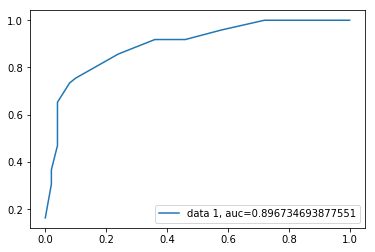

In [74]:
#plotting roc curve for logistic regression
y_pred_proba_lg = lg.predict_proba(X_dummy)[::,1]
fpr, tpr, _ = metrics.roc_curve(y,  y_pred_proba_lg)
auc = roc_auc_score(y, y_pred_proba_lg)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Text(0.5,1,'2-class Precision-Recall curve: AP={0:0.2f}')

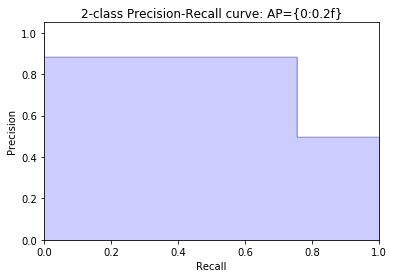

In [75]:
#plotting precison call for random forest model


# y_score_rf = rf.decision_function(X_test)
precision, recall, _ = precision_recall_curve(y, y_predict_lg)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}')

In [76]:
feature_importance = abs(lg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_importance

array([  0.43208876,  34.7848645 ,  15.4394526 ,  76.25653064,
        34.25310707,  34.25310707,  34.25310707,  67.63611952,
        53.70621441,  54.05046289,  53.70621441,  34.7848645 ,
        21.13578111,  90.57687487,  34.25310707,  21.13578111,
        21.13578111,  34.25310707,  34.7848645 ,  34.25310707,
        25.34800885,  34.25310707,  34.25310707,  34.7848645 ,
        43.45307645,  65.678507  ,  50.0460433 ,  34.7848645 ,
       100.        ,  34.25310707])

#### Random Forest with one feature *(location)*

In [77]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=300, random_state=90)
rf.fit(X_dummy, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=90, verbose=0, warm_start=False)

In [78]:
print('Cross val score', cross_val_score(rf, X_dummy, y, cv=5).mean())   
print('Score:', rf.score(X_dummy, y)) 

Cross val score 0.5952631578947368
Score: 0.8282828282828283


In [79]:
y_predict_rf= rf.predict(X_dummy)

#### Model evaluation & summary

In [80]:
print(metrics.accuracy_score(y, y_predict_rf))
print(metrics.roc_auc_score(y, y_predict_rf))
print(metrics.confusion_matrix(y, y_predict_rf))
print(metrics.classification_report(y, y_predict_rf))

0.8282828282828283
0.8275510204081633
[[45  5]
 [12 37]]
             precision    recall  f1-score   support

          0       0.79      0.90      0.84        50
          1       0.88      0.76      0.81        49

avg / total       0.83      0.83      0.83        99



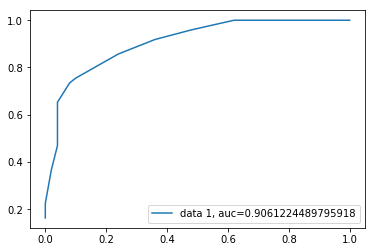

In [81]:
#plotting roc curve for random forest model
y_pred_proba_rf = rf.predict_proba(X_dummy)[::,1]
fpr, tpr, _ = metrics.roc_curve(y,  y_pred_proba_rf)
auc = metrics.roc_auc_score(y, y_pred_proba_rf)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Text(0.5,1,'2-class Precision-Recall curve: AP={0:0.2f}')

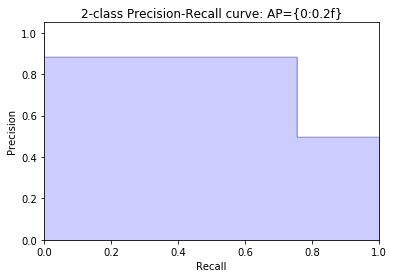

In [82]:
#plotting precison call for random forest model
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

# y_score_rf = rf.decision_function(X_test)
precision, recall, _ = precision_recall_curve(y, y_predict_rf)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}')

In [83]:
#feature importance
feature_importance_rf = abs(rf.feature_importances_)
feature_importance_rf = 100.0 * (feature_importance_rf / feature_importance_rf.max())
feature_importance_rf

array([ 11.10753282,  10.34086288,  19.27619459,  44.37566344,
        14.18167776,  13.06499501,  12.85254842,  66.56201635,
        21.81963106,  44.46362513,  23.58474518,  11.65024458,
        14.83344255,  63.29241792,  13.1577609 ,  13.48883815,
        16.30452996,  13.72465721,  10.94265707,  12.70293687,
        20.9514106 ,  13.46863256,  14.2053124 ,  10.49021027,
        28.43819261,  37.46182024,  36.44924732,  10.8824431 ,
       100.        ,  13.63404057])

#### Create a few new variables in your dataframe to represent interesting features of a job title.

In [84]:
unique_job=set(new_df.job_title.values)
unique_job 

{'AVMaps Workflow Technical Lead Manager / TLM',
 'Analyst | Data Analysis',
 'Assay Researcher (Sr. Research Assistant)',
 'Assistant Data Analyst (Data Analytics, Research and Innovation Team)',
 'Assistant/Associate Clipper Program Coordinator, Data Analysis',
 'Associate Data Scientist Intern',
 'Biostatistician I (Research Associate)',
 'COMPUTER SCIENTIST',
 'Coordinator Statistical Research I',
 'DATA SCIENTIST',
 'Data Science Manager',
 'Data Science Specialist',
 'Data Scientist',
 'Data Scientist (944)',
 'Data Scientist - Artificial Intelligence-PS16194',
 'Data Scientist - Cyber Security',
 'Data Scientist - Healthcare',
 'Data Scientist / Quantitative Researcher – High Frequency Futures',
 'Data Scientist Intern, PhD, 2019',
 'Data Scientist Internship',
 'Data Scientist, Analyst (Invest & Advice Products)',
 'Data Scientist, Insights',
 'Data Scientist, Personalization',
 'Data Scientist, Seller Modeling',
 'Data Scientist/GIS Analyst',
 'Digital Signal Processing Scient

In [85]:
new_df["manager"] = list(map(int, new_df["job_title"].str.lower().str.contains("manager")))
new_df["scientist"] = list(map(int, new_df["job_title"].str.lower().str.contains("scientist")))
new_df["analyst"] = list(map(int, new_df["job_title"].str.lower().str.contains("analy")))
new_df["associate"] = list(map(int, new_df["job_title"].str.lower().str.contains("associate")|new_df["job_title"].str.lower().str.contains("Assistant")))
new_df["engineer"] = list(map(int, new_df["job_title"].str.lower().str.contains("engineer")))
new_df["senior"] = list(map(int, new_df["job_title"].str.lower().str.contains("senior")|new_df["job_title"].str.lower().str.contains("snr")|new_df["job_title"].str.lower().str.contains("sr")))
new_df["instructor"] = list(map(int, new_df["job_title"].str.lower().str.contains("instructor")))
new_df["research"] = list(map(int, new_df["job_title"].str.lower().str.contains("research")))
new_df["coordinator"] = list(map(int, new_df["job_title"].str.lower().str.contains("coordinator")))
new_df["specialist"] = list(map(int, new_df["job_title"].str.lower().str.contains("special")))
job_title_feature_names=['scientist','analyst','associate',
                   'engineer','senior','instructor','research','coordinator','specialist']                        

for feature in job_title_feature_names:
    print(feature, new_df[feature].sum())

scientist 55
analyst 25
associate 9
engineer 8
senior 10
instructor 1
research 35
coordinator 2
specialist 2


In [86]:
new_df.columns

Index(['job_title', 'company_name', 'location', 'salary', 'avg_salary',
       'salary_binary', 'manager', 'scientist', 'analyst', 'associate',
       'engineer', 'senior', 'instructor', 'research', 'coordinator',
       'specialist'],
      dtype='object')

###### From the coefficients above we can infer that instructor roles are more associated with high salaries than engineer roles. We can also see that research roles are negatively associated with high salaries. 

In [87]:
# new_df = pd.get_dummies(new_df,columns=['location'])

In [88]:
df_dum = pd.get_dummies(new_df,columns=['location'])

In [89]:
new_df.head()

,job_title,company_name,location,salary,avg_salary,salary_binary,manager,scientist,analyst,associate,engineer,senior,instructor,research,coordinator,specialist
0,Data Scientist,Dollar Shave Club,Marina del Rey,"$101,000 - $148,000 a year (Indeed est.)",124500.0,1,0,1,0,0,0,0,0,0,0,0
1,Staff Data Scientist,Areté Associates,Northridge,"$95,000 - $140,000 a year (Indeed est.)",117500.0,1,0,1,0,0,0,0,0,0,0,0
2,NLP Data Scientist,Albert,Los Angeles,"$113,000 - $166,000 a year (Indeed est.)",139500.0,1,0,1,0,0,0,0,0,0,0,0
3,Data Scientist - Healthcare,Beyond Limits,Glendale,"$116,000 - $171,000 a year (Indeed est.)",143500.0,1,0,1,0,0,0,0,0,0,0,0
4,Data Scientist,Hearts and Science,Burbank,"$86,000 - $127,000 a year (Indeed est.)",106500.0,1,0,1,0,0,0,0,0,0,0,0


In [90]:
df_dum = df_dum.iloc[:,5:]

In [91]:
df_dum.columns

Index(['manager', 'scientist', 'analyst', 'associate', 'engineer', 'senior',
       'instructor', 'research', 'coordinator', 'specialist',
       'location_Atlanta', 'location_Aurora', 'location_Austin',
       'location_Boulder', 'location_Broomfield', 'location_Burbank',
       'location_Carnegie', 'location_Chicago', 'location_Dallas',
       'location_Denver', 'location_Duluth', 'location_Fort Lauderdale',
       'location_Glendale', 'location_Houston', 'location_Irving',
       'location_Los Angeles', 'location_Manhattan', 'location_Marina del Rey',
       'location_Miami', 'location_Mount Laurel', 'location_New York',
       'location_Northridge', 'location_Painted Post', 'location_Philadelphia',
       'location_Phoenix', 'location_Pittsburgh', 'location_Portland',
       'location_Queens', 'location_San Francisco', 'location_Tempe'],
      dtype='object')

In [95]:
X_dum = df_dum

y = new_df["salary_binary"]

In [96]:
#use logistic regression to predict salary
from sklearn.utils import shuffle

logreg = LogisticRegression()
logreg.fit(X_dum, y)
predictions = logreg.predict(X_dum)

In [97]:
print('cross_val_score: ',cross_val_score(logreg, X_dum, y).mean())
print('Score: ', logreg.score( X_dum, y))

cross_val_score:  0.7656899881164586
Score:  0.898989898989899


In [98]:
#use random forest to predict salary
rfc = RandomForestClassifier(n_estimators=300, random_state=90)
rfc.fit(X_dum, y)
print('cross_val_score: ',cross_val_score(rfc, X_dum, y).mean())
print('Score: ', rfc.score( X_dum, y))

cross_val_score:  0.7862076648841354
Score:  0.98989898989899


In [99]:
from sklearn.neighbors import KNeighborsClassifier

In [100]:
knn = KNeighborsClassifier()
knn.fit(X_dum, y)
print('cross_val_score: ',cross_val_score(knn, X_dum, y).mean())
print('Score: ', knn.score( X_dum, y))

cross_val_score:  0.7264743018419489
Score:  0.797979797979798


### Comparing cross validation of location and job title

In [101]:
print(' random forest Cross val score of location', cross_val_score(rf, X_dummy, y, cv=5).mean())
print(' logestic regression Cross val score of location:', cross_val_score(lg, X_dummy, y, cv=5).mean()) 
print('logestic regression Cross val score of job title and location feature :',cross_val_score(logreg, X_dum, y).mean())
print('knn cross_val_score of job title and location feature : ',cross_val_score(knn, X_dum, y).mean())
print(' random forest Cross val score of job title and location feature : ',cross_val_score(rfc, X_dum, y).mean())

 random forest Cross val score of location 0.5952631578947368
 logestic regression Cross val score of location: 0.5847368421052632
logestic regression Cross val score of job title and location feature : 0.7656899881164586
knn cross_val_score of job title and location feature :  0.7264743018419489
 random forest Cross val score of job title and location feature :  0.7862076648841354


Models with two features job title and location have higher cross validation score than models with one features location. As it is clear Random forest did better than others models.

In [102]:
print(' random forest score of location', rf.score( X_dummy, y))
print(' logestic regression score of location:', lg.score(X_dummy, y)) 
print('logestic regression score of job title and location feature :',logreg.score(X_dum, y))
print('knn score of job title and location feature : ',knn.score(X_dum, y))
print(' random forest score of job title and location feature : ',rfc.score( X_dum, y))

 random forest score of location 0.8282828282828283
 logestic regression score of location: 0.8282828282828283
logestic regression score of job title and location feature : 0.898989898989899
knn score of job title and location feature :  0.797979797979798
 random forest score of job title and location feature :  0.98989898989899


### BONUS

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

In [ ]:
## YOUR LINK HERE IN MARKDOWN FORMAT 